# Imports

In [26]:
# %load_ext autoreload
# %autoreload 2

# import glob
import os
# import re

# from joblib import Parallel, delayed
# import kmermaid_utils
import numpy as np
import pandas as pd
# import scanpy as sc
import seaborn as sns
# import sig_utils
# import sourmash
# from tqdm import tqdm

from path_constants import FIGURE_FOLDER

# pd.options.display.max_colwidth = 500
# pd.options.display.max_columns = 50

# from sourmash_search_utils import read_and_process_sourmash_search_results

In [10]:
from nb_utils import describe

# Get ideal ksizes per alphabet sizes

In [11]:
alphabet_sizes = pd.Series(dict(dayhoff=6, protein=20))  # hp=2,
np.log10(alphabet_sizes.pow(21 / 3))

dayhoff    5.447059
protein    9.107210
dtype: float64

In [12]:
ideal_ksizes = np.ceil(21 * np.log(4) / np.log(alphabet_sizes))
ideal_ksizes

dayhoff    17.0
protein    10.0
dtype: float64

In [13]:
np.log10(alphabet_sizes.pow(ideal_ksizes))

dayhoff    13.228571
protein    13.010300
dtype: float64

In [14]:
k_nuc_sizes = np.arange(21, 91, 3)
k_nuc_sizes

array([21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69,
       72, 75, 78, 81, 84, 87, 90])

In [15]:
k_aa_sizes = k_nuc_sizes/3
k_aa_sizes

array([ 7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.,
       20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.])

In [16]:
dna_entropy = pd.Series(k_nuc_sizes * np.log10(4), name='entropy', index=k_nuc_sizes)
dna_entropy = dna_entropy.reset_index()
dna_entropy = dna_entropy.rename(columns={'index': 'k_nuc'})
dna_entropy['alphabet'] = 'dna'
describe(dna_entropy)

(24, 3)
--- First 5 entries ---


,k_nuc,entropy,alphabet
0,21,12.64326,dna
1,24,14.44944,dna
2,27,16.25562,dna
3,30,18.06180,dna
4,33,19.86798,dna


In [17]:
aa_nuc_alphabet_sizes = alphabet_sizes.copy()
aa_nuc_alphabet_sizes['dna'] = 4

In [18]:
alphabet_complexity = alphabet_sizes.to_frame().apply(
    lambda x: pd.Series(k_aa_sizes * np.log10(x.iloc[0]), name=x.name), axis=1
)
alphabet_complexity.columns = k_nuc_sizes
alphabet_complexity = alphabet_complexity.unstack().reset_index()
alphabet_complexity = alphabet_complexity.rename(
    columns={"level_0": "k_nuc", "level_1": "alphabet", 0: "entropy"}
)
alphabet_complexity = pd.concat([alphabet_complexity, dna_entropy])
alphabet_complexity["k_aa"] = (alphabet_complexity["k_nuc"] / 3).astype(int)
alphabet_complexity["sigma"] = alphabet_complexity.alphabet.map(aa_nuc_alphabet_sizes)
alphabet_complexity["alphabet_type"] = alphabet_complexity.alphabet.map(
    lambda x: "nuc" if x == "dna" else "aa"
)
alphabet_complexity["alphabet_label"] = alphabet_complexity.apply(
    lambda x: "{alphabet} $|\Sigma_{{{alphabet_type}}}| = {sigma}$".format(**x), axis=1
)
describe(alphabet_complexity)

(72, 7)
--- First 5 entries ---


,k_nuc,alphabet,entropy,k_aa,sigma,alphabet_type,alphabet_label
0,21,dayhoff,5.447059,7,6,aa,dayhoff $|\Sigma_{aa}| = 6$
1,21,protein,9.107210,7,20,aa,protein $|\Sigma_{aa}| = 20$
2,24,dayhoff,6.225210,8,6,aa,dayhoff $|\Sigma_{aa}| = 6$
3,24,protein,10.408240,8,20,aa,protein $|\Sigma_{aa}| = 20$
4,27,dayhoff,7.003361,9,6,aa,dayhoff $|\Sigma_{aa}| = 6$


In [19]:
sorted(alphabet_complexity.alphabet_label.unique())

['dayhoff $|\\Sigma_{aa}| = 6$',
 'dna $|\\Sigma_{nuc}| = 4$',
 'protein $|\\Sigma_{aa}| = 20$']

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/seaborn/categorical.py:3737: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


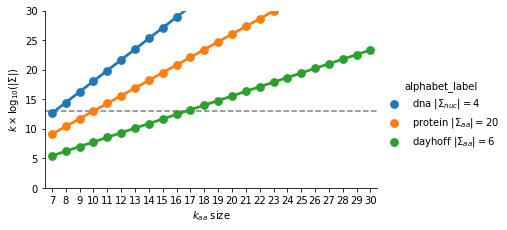

In [28]:
alphabet_order = [
    "dna $|\\Sigma_{nuc}| = 4$",
    "protein $|\\Sigma_{aa}| = 20$",
    "dayhoff $|\\Sigma_{aa}| = 6$",
    #     "hp $|\\Sigma_{aa}| = 2$",
]

g = sns.catplot(
    x="k_aa",
    data=alphabet_complexity,
    y="entropy",
    hue="alphabet_label",
    kind="point",
    size=3,
    aspect=1.75,
    hue_order=alphabet_order,
)

# entropy_min = alphabet_complexity.query(
#     'k_nuc == 63 and alphabet == "hp"'
# ).entropy.iloc[0]
# entropy_max = alphabet_complexity.query(
#     'k_nuc == 60 and alphabet == "dayhoff"'
# ).entropy.iloc[0]

for ax in g.axes.flat:
    #     xmin, xmax = ax.get_xlim()
    #     ax.fill_between(
    #         (xmin, xmax), entropy_min, entropy_max, color="lightgrey", zorder=-1
    #     )
    ax.axhline(10 * np.log10(20), color="grey", linestyle="--", zorder=-1)
#     ax.axhline(entropy_max, color="grey", linestyle="--", zorder=-1)

g.set(
    ylabel=r"$k \times \log_{10} \left( | \Sigma | \right)$",
    #     xlim=(xmin, xmax),
    ylim=(0, 30),
    xlabel=r"$k_{aa}$ size",
)
figure_folder = os.path.join(FIGURE_FOLDER, "alphabet_size_vs_complexity")
! mkdir -p $figure_folder
pdf = os.path.join(figure_folder, "alphabet_size_vs_complexity.pdf")
g.savefig(pdf)